In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
!unzip ./drive/MyDrive/DAVIS.zip -d ./

Streaming output truncated to the last 5000 lines.
  inflating: ./DAVIS/JPEGImages/480p/swing/00018.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00018.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00030.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00030.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00024.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00024.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00032.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00032.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00026.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00026.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00027.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00027.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00033.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/swing/._00033.jpg  
  inflating: ./DAVIS/JPEGImages/480p/swing/00037.jpg  
  inflating: ./__MACOSX/DAVIS/JPEGImages/480p/s

In [3]:
import pandas as pd

train_df = pd.read_csv('./DAVIS/ImageSets/480p/train.txt', header=None, sep='\s+')
val_df = pd.read_csv('./DAVIS/ImageSets/480p/val.txt', header=None, sep='\s+')

columns = ['image_path', 'mask_path']
train_df.columns = columns
val_df.columns = columns

In [4]:
train_df.head()

,image_path,mask_path
0,/JPEGImages/480p/bear/00000.jpg,/Annotations/480p/bear/00000.png
1,/JPEGImages/480p/bear/00001.jpg,/Annotations/480p/bear/00001.png
2,/JPEGImages/480p/bear/00002.jpg,/Annotations/480p/bear/00002.png
3,/JPEGImages/480p/bear/00003.jpg,/Annotations/480p/bear/00003.png
4,/JPEGImages/480p/bear/00004.jpg,/Annotations/480p/bear/00004.png


In [5]:
from torch.utils.data import Dataset
from PIL import Image

class DAVIS(Dataset):
    def __init__(self, root_dir, dataset_df, transform=None):
        self.root_dir = root_dir
        self.dataset_df = dataset_df
        self.transform = transform

    def __len__(self):
        return len(self.dataset_df)

    def __getitem__(self, idx):
        image_path = self.root_dir + self.dataset_df.iloc[idx]['image_path']
        mask_path = self.root_dir + self.dataset_df.iloc[idx]['mask_path']

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [6]:
from torchvision import transforms as T

my_transforms = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    ])

train_dataset = DAVIS('./DAVIS/', train_df, my_transforms)
val_dataset = DAVIS('./DAVIS/', val_df, my_transforms)

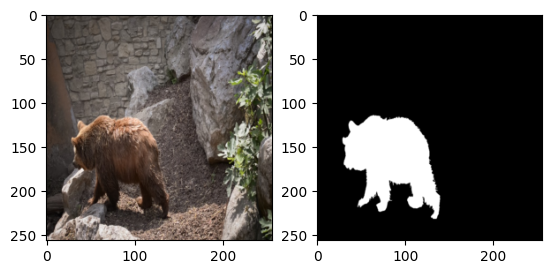

In [7]:
import matplotlib.pyplot as plt
images, masks = next(iter(train_dataset))
plt.subplot(1,2,1)
plt.imshow(images.permute(1, 2, 0))
plt.subplot(1,2,2)
plt.imshow(masks[0], cmap='gray')
plt.show()

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=12, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=12, shuffle=False)

In [9]:
class DoubleConv(nn.Module):
    """(conv => ReLU => BN) * 2"""
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.down = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.down(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super(Up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # for padding issues, see https://github.com/Haiyong-SUN/U-Net/issues/5
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [16]:
device

device(type='cuda')

In [10]:
model = UNet(n_channels=3, n_classes=1)  # For a binary segmentation with RGB input

In [15]:
model = model.to(device)

In [11]:
input_image = torch.randn(1, 3, 256, 256)  # Example input tensor
output = model(input_image)
print(output.shape)  # Should match the input spatial dimensions with n_classes channels

torch.Size([1, 1, 256, 256])


In [17]:
# Custom Multi-Class Dice loss implementation
class DiceLoss(nn.Module):
    def __init__(self, smooth=1):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # Apply sigmoid to logits to get probabilities
        logits = torch.sigmoid(logits)

        # Flatten the tensors
        logits = logits.view(-1)
        targets = targets.view(-1)

        # Calculate intersection and union
        intersection = (logits * targets).sum()
        union = logits.sum() + targets.sum()

        # Calculate Dice coefficient
        dice = (2. * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice

In [18]:
# Define the loss function
cross_entropy_loss = nn.CrossEntropyLoss()
dice_loss = DiceLoss()  # Custom Dice loss for multi-class (implementation required)

def combined_loss(output, target):
    ce = cross_entropy_loss(output, target)
    dice = dice_loss(output, target)
    return ce + dice

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [19]:
n_epochs = 5

for epoch in range(n_epochs):
    model.train()
    for bid, (images, masks) in enumerate(train_dataloader):
        images = images.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{n_epochs}, Batch: {bid}, Loss: {loss.item()}")

Epoch 1/5, Batch: 0, Loss: 0.8621885180473328
Epoch 1/5, Batch: 1, Loss: 0.8388281464576721
Epoch 1/5, Batch: 2, Loss: 0.8062554597854614
Epoch 1/5, Batch: 3, Loss: 0.6993664503097534
Epoch 1/5, Batch: 4, Loss: 0.7883737087249756
Epoch 1/5, Batch: 5, Loss: 0.7234253287315369
Epoch 1/5, Batch: 6, Loss: 0.7347444295883179
Epoch 1/5, Batch: 7, Loss: 0.7718340754508972
Epoch 1/5, Batch: 8, Loss: 0.8001631498336792
Epoch 1/5, Batch: 9, Loss: 0.7165579795837402
Epoch 1/5, Batch: 10, Loss: 0.7501099109649658
Epoch 1/5, Batch: 11, Loss: 0.7323713302612305
Epoch 1/5, Batch: 12, Loss: 0.6346485614776611
Epoch 1/5, Batch: 13, Loss: 0.7846016883850098
Epoch 1/5, Batch: 14, Loss: 0.7306562662124634
Epoch 1/5, Batch: 15, Loss: 0.7146326899528503
Epoch 1/5, Batch: 16, Loss: 0.7775124907493591
Epoch 1/5, Batch: 17, Loss: 0.6457449793815613
Epoch 1/5, Batch: 18, Loss: 0.661158561706543
Epoch 1/5, Batch: 19, Loss: 0.6745996475219727
Epoch 1/5, Batch: 20, Loss: 0.722657322883606
Epoch 1/5, Batch: 21, Los

In [31]:
images, masks = next(iter(train_dataloader))

In [32]:
pred_masks = model(images.to(device)).detach().cpu()

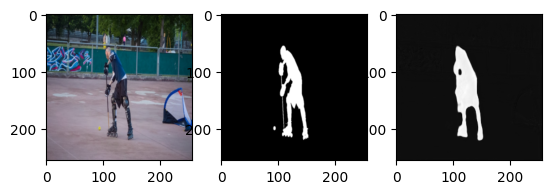

In [33]:
import matplotlib.pyplot as plt
idx = -5
plt.subplot(1,3,1)
plt.imshow(images[idx].permute(1, 2, 0))
plt.subplot(1,3,2)
plt.imshow(masks[idx][0], cmap='gray')
plt.subplot(1,3,3)
plt.imshow(pred_masks[idx][0], cmap='gray')
plt.show()